# Activity Investigation

This should be helpful when I just want to look closely at the results of a particular activity stream

In [1]:
from strava.data.cache import Cache
from strava.data.strava_requests import *
from strava.plotting.strava_annual_plots import *
from strava.plotting.strava_stream_plots import *
from generate_plots import get_clean_activities, get_clean_stream
from strava.data.cache import Cache

import aiohttp
import asyncio
import copy
from datetime import date
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import requests
import os
import pandas as pd
from pandas_profiling import ProfileReport
from plotnine import ggplot, aes
import plotnine as gg
import time
from typing import List
import urllib3
import PIL
from PIL import Image
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
gg.options.figure_size = (11, 8.5)
pt.dark()
pt.light()

pd.set_option('display.max_columns', 500)

%load_ext autoreload
%autoreload 2

In [2]:
segment_plot_path = '/Users/lucasnieuwenhout/Documents/Programming/Python/Projects/StravaPlotting/plots/segments/'

In [3]:
# Create a cache
stream_cache = Cache()
activity_cache = Cache(dir='/Users/lucasnieuwenhout/Documents/Programming/Python/Projects/StravaPlotting/activity_cache/')

In [4]:
# Get a list of activities
activities = get_clean_activities()
activities.tail()

Requesting new token...
Token received.
Beginning request of activities...
-> Received page 1 with 200 activities.
-> Received page 2 with 200 activities.
-> Received page 3 with 200 activities.
-> Received page 4 with 42 activities.
-> Received page 5 with 0 activities.
...retrieved total of 642 activities.


,id,name,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,sport_type,start_date_local,timezone,start_latlng,end_latlng,achievement_count,map.id,workout_type,average_speed,max_speed,average_heartrate,max_heartrate,map.summary_polyline,year,date_year_agnostic
636,3425015993,Afternoon Ride,8964.6,0 days 00:26:43,0 days 00:26:43,39.0,693.8,654.7,Ride,2020-04-26 15:07:20,(GMT-07:00) America/Edmonton,"[53.636688, -113.587822]","[53.636729, -113.587903]",0,a3425015993,10.0,20.1312,40.32,165.0,185.0,{mjfIhhjtTt@fAf@|@HREZUpAe@pB{@vC]z@a@r@k@x@c@...,2020,1970-04-26 15:07:20
637,3425016238,Lunch Ride,17516.8,0 days 00:48:11,0 days 00:48:11,71.2,693.8,653.7,Ride,2020-04-25 11:48:43,(GMT-07:00) America/Edmonton,"[53.636724, -113.587843]","[53.636742, -113.587806]",0,a3425016238,10.0,21.8124,50.04,178.0,194.0,knjfIrhjtT`AxAb@v@G|@UvA[pAw@fCy@hBg@t@g@l@u@n...,2020,1970-04-25 11:48:43
638,3425017204,Afternoon Ride,14517.0,0 days 00:47:28,0 days 00:47:28,64.1,693.8,653.7,Ride,2020-04-23 13:02:13,(GMT-07:00) America/Edmonton,"[53.636938, -113.587945]","[53.636747, -113.58785]",0,a3425017204,10.0,18.3492,36.72,175.4,198.0,qnjfIlhjtTfAvAl@bAEp@OdA]hBc@lBW~@]~@Yj@g@t@_@...,2020,1970-04-23 13:02:13
639,3425016478,Afternoon Ride,17605.8,0 days 00:57:41,0 days 00:57:41,69.9,693.8,653.7,Ride,2020-04-22 14:48:16,(GMT-07:00) America/Edmonton,"[53.636929, -113.587659]","[53.636694, -113.587956]",0,a3425016478,10.0,18.3132,39.96,176.6,194.0,wmjfIdhjtTx@pAZv@F^?XAb@EZUt@[r@qBpCw@rA_@b@s@...,2020,1970-04-22 14:48:16
641,3425016348,Afternoon Ride,7278.0,0 days 00:23:28,0 days 00:23:28,21.9,693.8,684.9,Ride,2020-04-16 13:57:58,(GMT-07:00) America/Edmonton,"[53.636894, -113.587782]","[53.636646, -113.587864]",0,a3425016348,10.0,18.6084,36.00,177.8,197.0,uojfIxhjtTvB|CjAnBbApBlA|CXdC^tEL`CB|ACtBKjBs@...,2020,1970-04-16 13:57:58


# Explore Activity API

What do I actually want to do?
- Plot my progress on segments of interest
- Plot how many of the 37 segments I have local legend on
- Get a list of the canonical segments and find my time vs. the best time?
- 

In [5]:
activities

,id,name,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,sport_type,start_date_local,timezone,start_latlng,end_latlng,achievement_count,map.id,workout_type,average_speed,max_speed,average_heartrate,max_heartrate,map.summary_polyline,year,date_year_agnostic
0,14307309734,Afternoon Ride,26564.7,0 days 01:06:34,0 days 01:10:29,351.3,100.6,4.4,Ride,2025-04-27 15:06:20,(GMT-08:00) America/Vancouver,"[49.055026, -122.774621]","[49.055073, -122.774604]",7,a14307309734,NaN,23.9436,51.696,165.4,185.0,o~kjH`sjlV@n@BZ`@x@RhBp@jCFjAX`@P`@BlAJj@HNNBb...,2025,1970-04-27 15:06:20
1,14296525748,Afternoon Ride,28427.8,0 days 01:10:45,0 days 01:13:04,352.3,100.6,3.4,Ride,2025-04-26 16:21:07,(GMT-08:00) America/Vancouver,"[49.055061, -122.774509]","[49.055059, -122.774641]",6,a14296525748,NaN,24.1092,50.328,171.3,189.0,w`ljHhtjlVZSZCLSFBA|@DN\l@LtAt@bDJtAf@v@FrAPt@...,2025,1970-04-26 16:21:07
2,14277777811,Afternoon Ride,28439.2,0 days 01:12:05,0 days 01:14:49,352.4,100.6,3.4,Ride,2025-04-24 16:42:09,(GMT-08:00) America/Vancouver,"[49.055104, -122.774563]","[49.055067, -122.774657]",2,a14277777811,NaN,23.6736,60.408,175.6,190.0,u`ljHptjlVb@YPCPYDPAt@b@dANzAn@dCNhB\`@HVFrANl...,2025,1970-04-24 16:42:09
4,14246648380,Afternoon Ride,28549.4,0 days 01:13:12,0 days 01:15:12,354.3,100.6,3.4,Ride,2025-04-21 13:54:15,(GMT-08:00) America/Vancouver,"[49.055032, -122.774484]","[49.055061, -122.774616]",8,a14246648380,10.0,23.4000,58.536,171.6,193.0,u`ljHjtjlVb@YN?NSHFCR@f@d@z@HjAt@`DJvAFRd@x@Bh...,2025,1970-04-21 13:54:15
5,14218149073,Afternoon Ride,28507.2,0 days 01:17:43,0 days 01:19:52,352.0,100.6,3.4,Ride,2025-04-18 16:41:11,(GMT-08:00) America/Vancouver,"[49.055033, -122.7746]","[49.055058, -122.77465]",4,a14218149073,10.0,22.0068,59.184,167.7,189.0,e_ljHpsjlVPUDFDbA`@x@JtAn@hCPhBh@x@F`BPh@LHjCG...,2025,1970-04-18 16:41:11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,3425015993,Afternoon Ride,8964.6,0 days 00:26:43,0 days 00:26:43,39.0,693.8,654.7,Ride,2020-04-26 15:07:20,(GMT-07:00) America/Edmonton,"[53.636688, -113.587822]","[53.636729, -113.587903]",0,a3425015993,10.0,20.1312,40.320,165.0,185.0,{mjfIhhjtTt@fAf@|@HREZUpAe@pB{@vC]z@a@r@k@x@c@...,2020,1970-04-26 15:07:20
636,3425016238,Lunch Ride,17516.8,0 days 00:48:11,0 days 00:48:11,71.2,693.8,653.7,Ride,2020-04-25 11:48:43,(GMT-07:00) America/Edmonton,"[53.636724, -113.587843]","[53.636742, -113.587806]",0,a3425016238,10.0,21.8124,50.040,178.0,194.0,knjfIrhjtT`AxAb@v@G|@UvA[pAw@fCy@hBg@t@g@l@u@n...,2020,1970-04-25 11:48:43
637,3425017204,Afternoon Ride,14517.0,0 days 00:47:28,0 days 00:47:28,64.1,693.8,653.7,Ride,2020-04-23 13:02:13,(GMT-07:00) America/Edmonton,"[53.636938, -113.587945]","[53.636747, -113.58785]",0,a3425017204,10.0,18.3492,36.720,175.4,198.0,qnjfIlhjtTfAvAl@bAEp@OdA]hBc@lBW~@]~@Yj@g@t@_@...,2020,1970-04-23 13:02:13
638,3425016478,Afternoon Ride,17605.8,0 days 00:57:41,0 days 00:57:41,69.9,693.8,653.7,Ride,2020-04-22 14:48:16,(GMT-07:00) America/Edmonton,"[53.636929, -113.587659]","[53.636694, -113.587956]",0,a3425016478,10.0,18.3132,39.960,176.6,194.0,wmjfIdhjtTx@pAZv@F^?XAb@EZUt@[r@qBpCw@rA_@b@s@...,2020,1970-04-22 14:48:16


In [6]:
activ_id = activity_id_by_date(activities=activities, date=datetime.date(2025, 4, 26))
activity_detail = get_activity_detail(activities, activ_id, activity_cache, include_all_efforts=True)

Found activity 14296525748 in cache.


In [7]:
def activity_detail_print_simple_summary(activity_detail):
    """Print simple summary of activity"""
    print(f"Date: \t\t{activity_detail['start_date_local'].split('T')[0]}")
    print(f"Name: \t\t{activity_detail['name']}")
    print(f"Distance: \t{activity_detail['distance'] / 1000:0.3f} km")
    print(f"Time: \t\t{activity_detail['moving_time'] // 3600}:{activity_detail['moving_time'] % 3600 // 60}:{activity_detail['moving_time'] % 60}")
    print(f"Elevation: \t{activity_detail['total_elevation_gain']} m")
    print(f"Achievements: \t{activity_detail['achievement_count']}")
    print(f"Average Speed: \t{activity_detail['average_speed'] / 1000 * 3600:0.2f} km/h")
    print(f"Average HR: \t{round(activity_detail['average_heartrate'])}")
    print(f"Segments: \t{len(activity_detail['segment_efforts'])}")

activity_detail_print_simple_summary(activity_detail)

Date: 		2025-04-26
Name: 		Afternoon Ride
Distance: 	28.428 km
Time: 		1:10:45
Elevation: 	352.3 m
Achievements: 	6
Average Speed: 	24.11 km/h
Average HR: 	171
Segments: 	37


In [8]:
activity_detail['segment_efforts'][0]

{'id': 3351372218722475890,
 'resource_state': 2,
 'name': '28th - it says bike route....',
 'activity': {'id': 14296525748,
  'visibility': 'everyone',
  'resource_state': 1},
 'athlete': {'id': 56778178, 'resource_state': 1},
 'elapsed_time': 105,
 'moving_time': 105,
 'start_date': '2025-04-26T23:23:13Z',
 'start_date_local': '2025-04-26T16:23:13Z',
 'distance': 734.2,
 'start_index': 120,
 'end_index': 225,
 'device_watts': False,
 'average_heartrate': 172.0,
 'max_heartrate': 180.0,
 'segment': {'id': 31582444,
  'resource_state': 2,
  'name': '28th - it says bike route....',
  'activity_type': 'Ride',
  'distance': 734.2,
  'average_grade': 2.0,
  'maximum_grade': 5.1,
  'elevation_high': 75.2,
  'elevation_low': 58.6,
  'start_latlng': [49.052882, -122.78008],
  'end_latlng': [49.052823, -122.790121],
  'elevation_profile': None,
  'elevation_profiles': None,
  'climb_category': 0,
  'city': 'Surrey',
  'state': 'British Columbia',
  'country': 'Canada',
  'private': False,
  'h

In [9]:
# id(segment effort id), name, elapsed_time, moving_time, distance, average_heartrate, max_heartrate, segment
#  - name, distance, average_grade, maximum_grade, elevation_high, elevation_low, hazardous, pr_rank, achievements
#    - type, rank, effort_count

#   'resource_state': 2,
#   'name': '28th - it says bike route....',
#   'activity_type': 'Ride',
#   'distance': 734.2,
#   'average_grade': 2.0,
#   'maximum_grade': 5.1,
#   'elevation_high': 75.2,
#   'elevation_low': 58.6,
#   'start_latlng': [49.052882, -122.78008],
#   'end_latlng': [49.052823, -122.790121],
#   'elevation_profile': None,
#   'elevation_profiles': None,
#   'climb_category': 0,
#   'city': 'Surrey',
#   'state': 'British Columbia',
#   'country': 'Canada',
#   'private': False,
#   'hazardous': False,
#   'starred': False},
#  'pr_rank': None,
#  'achievements': [{'type_id': 7,
#    'type': 'segment_effort_count_leader',
#    'rank': 1,
#    'effort_count': 10}],

# Achievements
# Achievements is a list of dictinoaries holding various things
# - type_id = 7: 'type': 'segment_effort_count_leader', 'rank': 1, 'effort_count'
# - type_id = 3: 'type': 'pr', 'rank'
# - type_id = 2: 'type': 'overall', 'rank'

seg_df = []
for seg in activity_detail['segment_efforts']:
    segment_detail = [seg['id']]
    segment_detail.append(seg['segment']['id'])
    segment_detail.append(seg['name'])
    segment_detail.append(seg['distance'])
    segment_detail.append(seg['moving_time'])
    segment_detail.append(seg['average_heartrate'])
    segment_detail.append(seg['segment']['average_grade'])
    segment_detail.append(seg['segment']['hazardous'])
    segment_detail.append(seg['pr_rank'])
    segment_detail.append(seg['achievements'])
    if len(seg['achievements']) > 0:
        print(seg['achievements'])


    seg_df.append(segment_detail)
seg_df = pd.DataFrame(seg_df)
seg_df.columns = ['Effort ID', 'Segment ID', 'Name', 'Distance[m]', 'Moving Time[s]', 'Average HR', 'Average Grade', 'Hazardous', 'PR Rank', 'Achievements']

seg_df

[{'type_id': 7, 'type': 'segment_effort_count_leader', 'rank': 1, 'effort_count': 10}]
[{'type_id': 7, 'type': 'segment_effort_count_leader', 'rank': 1, 'effort_count': 10}]
[{'type_id': 7, 'type': 'segment_effort_count_leader', 'rank': 1, 'effort_count': 10}]
[{'type_id': 3, 'type': 'pr', 'rank': 3}]
[{'type_id': 3, 'type': 'pr', 'rank': 2}]
[{'type_id': 7, 'type': 'segment_effort_count_leader', 'rank': 1, 'effort_count': 10}]
[{'type_id': 7, 'type': 'segment_effort_count_leader', 'rank': 1, 'effort_count': 10}]
[{'type_id': 7, 'type': 'segment_effort_count_leader', 'rank': 1, 'effort_count': 10}]
[{'type_id': 7, 'type': 'segment_effort_count_leader', 'rank': 1, 'effort_count': 10}]
[{'type_id': 3, 'type': 'pr', 'rank': 3}, {'type_id': 7, 'type': 'segment_effort_count_leader', 'rank': 1, 'effort_count': 10}]
[{'type_id': 3, 'type': 'pr', 'rank': 2}]
[{'type_id': 3, 'type': 'pr', 'rank': 3}, {'type_id': 7, 'type': 'segment_effort_count_leader', 'rank': 1, 'effort_count': 10}]
[{'type_i

,Effort ID,Segment ID,Name,Distance[m],Moving Time[s],Average HR,Average Grade,Hazardous,PR Rank,Achievements
0,3351372218722475890,31582444,28th - it says bike route....,734.200,105,172.0,2.0,False,NaN,"[{'type_id': 7, 'type': 'segment_effort_count_..."
1,3351372218722545522,25667954,KG to 20 on 156,474.000,49,180.9,-0.1,False,NaN,[]
2,3351372218723331954,10267456,It smells richer in White Rock,1729.200,221,185.0,0.1,False,NaN,"[{'type_id': 7, 'type': 'segment_effort_count_..."
3,3351372218724073330,20245971,The Leafs Blow,374.900,49,155.4,-4.9,False,NaN,"[{'type_id': 7, 'type': 'segment_effort_count_..."
4,3351372218724823922,1145071,Marine Drive Rollers,1888.500,331,160.7,-0.2,True,NaN,[]
5,3351372218722127730,3935337,white rockin',1847.700,326,160.9,-0.3,True,NaN,[]
6,3351372218724694898,19129655,Cruisin' East Beach - Westbound,404.600,61,154.4,0.4,False,NaN,[]
7,3351372218723083122,16233163,marine kicker,317.200,62,180.4,6.4,False,NaN,[]
8,3351372218723396466,19059308,Rollin' Restaurant Row,616.400,131,154.6,-1.1,False,NaN,[]
9,3351372218723418994,19628715,Hotties & Hot Rods,486.600,58,155.8,0.7,False,NaN,[]


# Explore Segment API
- This is quite interesting...
- I can't use the segment effort api, but I can use the segment detail one.  This holds the kom and local legend details.


- Would be good to pull this information for each segment.  Compare against my best efforts.
- Can plot average time per month or season or something, or best time per month/season.
  - Could potentially plot the heartrate for the best effort?  Or the maximum speed?

In [10]:
segment_effort_url = "https://www.strava.com/api/v3/segments/"

In [11]:
def request_segment(segment_id: int):
    """Request activity data."""
    segment_effort_url = "https://www.strava.com/api/v3/segments/"

    # Set up request parameters
    header = {'Authorization': 'Bearer ' + get_access_token()}
    url = segment_effort_url + str(segment_id)

    # Request the streams
    stream_resp = requests.get(url, headers=header)
    if stream_resp.status_code != 200:
        print(f"Request failed, status code: {stream_resp.status_code}")
        return None

    print(f"Received {len(stream_resp.content)} bytes.")
    return stream_resp

In [12]:
r = request_segment(31582444)

Existing access token is valid.
Received 1769 bytes.


In [13]:
json.loads(r.content)

{'id': 31582444,
 'resource_state': 3,
 'name': '28th - it says bike route....',
 'activity_type': 'Ride',
 'distance': 734.2,
 'average_grade': 2.0,
 'maximum_grade': 5.1,
 'elevation_high': 75.2,
 'elevation_low': 58.6,
 'start_latlng': [49.052882, -122.78008],
 'end_latlng': [49.052823, -122.790121],
 'elevation_profile': 'https://d3o5xota0a1fcr.cloudfront.net/v6/charts/BRLSPYSPS7J4TCZ3QJO3W62FBPDAQRLHHAVJ4KOLRZDFLOBZOLWP5ZNDURNWZHIIESTCAFPJ5YKOLFLK5ZF3FIOO',
 'elevation_profiles': {'light_url': 'https://d3o5xota0a1fcr.cloudfront.net/v6/charts/BRLSPYSPS7J4TCZ3QJO3W62FBPDAQRLHHAVJ4KOLRZDFLOBZOLWP5ZNDURNWZHIIESTCAFPJ5YKOLFLK5ZF3FIOO',
  'dark_url': 'https://d3o5xota0a1fcr.cloudfront.net/v6/charts/SE4BUDO3W6BSEJDS43J4YZB3TTI7BEN5FJ7IFWPEWDQDFOE7TX4G2RFSCRFJU6OJZCTWRM2CXW6AXMTDT4P6XJDS'},
 'climb_category': 0,
 'city': 'Surrey',
 'state': 'British Columbia',
 'country': 'Canada',
 'private': False,
 'hazardous': False,
 'starred': False,
 'created_at': '2022-04-24T20:34:56Z',
 'updated_

1. Find all of the unique segments in BC.  Save the information about local legend and KOM.
2. Find all of the unique efforts from my rides that match those segments.
3. ???
4. Profit

In [7]:
class SegmentEffort:
    
    def __init__(self, effort):

        self.id = effort['id']
        self.activity_id = effort['activity']['id']
        self.segment_name = effort['name']
        self.elapsed_time = effort['elapsed_time']
        self.moving_time = effort['moving_time']
        self.start_date_local = effort['start_date_local']
        self.average_heartrate = effort['average_heartrate']
        self.max_heartrate = effort['max_heartrate']
        self.pr_rank = effort['pr_rank']
        self.achievements = effort['achievements']
        self.segment = effort['segment']

class Segment:
    # I think that I should make the main method of getting data just to use the effort stats.
    # If I really want to then I can query Stava for the KOM or something

    def __init__(self, id: int):

        self.id = id

        self._segment_content = None

        self._efforts: list[SegmentEffort] = []
        self.number_efforts = 0

    @property
    def segment_content(self, force: bool=False):

        if not force:
            print(f"If this is done in a loop, it will likely nuke the rate limit.  Currently 200 every 15 minutes, 2000 per day.")
            return None

        if self._segment_content is None:
            self.request_segment_details()
        return self._segment_content
    
    def request_segment_details(self):
        """Request segment data."""
        segment_effort_url = "https://www.strava.com/api/v3/segments/"

        # Set up request parameters
        header = {'Authorization': 'Bearer ' + get_access_token()}
        url = segment_effort_url + str(self.id)

        # Request the streams
        stream_resp = requests.get(url, headers=header)
        if stream_resp.status_code != 200:
            print(f"Request failed, status code: {stream_resp.status_code}")
            return None

        print(f"Received {len(stream_resp.content)} bytes.")

        self._segment_content = json.loads(stream_resp.content)
    
    @property
    def efforts(self):
        return self._efforts
    
    def effort_df(self):
        eff_df = []
        for eff in self._efforts:
            eff_rec = [eff.id]
            eff_rec.append(self.id)
            eff_rec.append(eff.activity_id)
            eff_rec.append(eff.segment_name)
            eff_rec.append(eff.elapsed_time)
            eff_rec.append(eff.moving_time)
            eff_rec.append(eff.start_date_local)
            eff_rec.append(eff.average_heartrate)
            eff_rec.append(eff.max_heartrate)
            eff_rec.append(eff.pr_rank)
            eff_df.append(eff_rec)
        
        # Combine to df
        eff_df = pd.DataFrame(eff_df, columns=['EffortID', 'SegmentID', 'ActivityID', 'SegmentName', 'ElapsedTime[s]', 'MovingTime[s]', 'StartDateLocal', 'AverageHR', 'MaxHR', 'PRRank'])

        # Clean and util
        eff_df['DateTime'] = pd.to_datetime(eff_df.StartDateLocal)
        eff_df = eff_df.sort_values('DateTime').reset_index(drop=True)
        eff_df['DateTimeIndex'] = range(1, len(eff_df) + 1)

        activity_index_lookup = {x: i for i, x in enumerate(sorted(eff_df.ActivityID.unique()))}
        eff_df['ActivityIndex'] = eff_df.ActivityID.map(activity_index_lookup)

        return eff_df
    
    def add_effort(self, effort):
        self._efforts.append(SegmentEffort(effort))
        self.number_efforts += 1
    
    def seg_data(self):
        if not self.number_efforts:
            return None
        
        return self._efforts[0].segment
    
    def __str__(self):
        return f"Segment: {self.id}, {self.number_efforts} efforts"
    
    def __eq__(self, other):
        return isinstance(other, Segment) and self.id == other.id


## Segments in BC

In [17]:
# Find the BC activities by filtering to rides below latitude of 50
bc_activities = activities[activities.start_latlng.apply(lambda x: float(x[0])) < 50]
segment_ids = set()
segments = {}
for act_id in bc_activities.id:
    ad = get_activity_detail(activities, act_id, activity_cache, include_all_efforts=True)
    for effort in ad['segment_efforts']:
        
        # If the segment is not already in the list, add it
        if effort['segment']['id'] not in segments:
            segments[effort['segment']['id']] = Segment(id=effort['segment']['id'])

        # Add the effort to the segment
        segments[effort['segment']['id']].add_effort(effort)

segment_id_lookup = {}
for k, v in segments.items():
    print(f"{k}: {v.efforts[0].segment_name}: {v}")
    segment_id_lookup[k] = v.efforts[0].segment_name

Found activity 14307309734 in cache.
Found activity 14296525748 in cache.
Found activity 14277777811 in cache.
Found activity 14246648380 in cache.
Found activity 14218149073 in cache.
Found activity 14208696270 in cache.
Found activity 14180028159 in cache.
Found activity 14169893236 in cache.
Found activity 14150724069 in cache.
Found activity 14132622357 in cache.
Found activity 14082982033 in cache.
Found activity 14073578110 in cache.
Found activity 11214280814 in cache.
Found activity 10818058984 in cache.
Found activity 10045628823 in cache.
Found activity 10033794476 in cache.
Found activity 10028527513 in cache.
Found activity 10003148059 in cache.
Found activity 9996006537 in cache.
Found activity 9990461310 in cache.
Found activity 9985137901 in cache.
Found activity 9978987119 in cache.
Found activity 9946322578 in cache.
Found activity 9940528230 in cache.
Found activity 9911215580 in cache.
Found activity 9902256544 in cache.
Found activity 9890069161 in cache.
Found acti

In [16]:
common_segments = {k: v for k, v in segments.items() if v.number_efforts > 50}
eff_df = []
for seg_id, seg in common_segments.items():
    for effort in seg.efforts:
        eff_df.append([seg_id, segment_id_lookup[seg_id], effort.activity_id, effort.id, effort.start_date_local, effort.moving_time, effort.average_heartrate, effort.pr_rank])

eff_df = pd.DataFrame(eff_df, columns=['SegmentID', 'SegmentName', 'ActivityID', 'EffortID', 'DateTime', 'MovingTime', 'AverageHR', 'PRRank'])
eff_df['DateTime'] = pd.to_datetime(eff_df.DateTime)
eff_df['EffortIndex'] = eff_df.sort_values('DateTime').groupby('SegmentID').cumcount()

activity_index_lookup = {x: i for i, x in enumerate(sorted(eff_df.ActivityID.unique()))}
eff_df['ActivityIndex'] = eff_df.ActivityID.map(activity_index_lookup)

eff_df

,SegmentID,SegmentName,ActivityID,EffortID,DateTime,MovingTime,AverageHR,PRRank,EffortIndex,ActivityIndex
0,31582444,28th - it says bike route....,14307309734,3351715314419615886,2025-04-27 15:08:20+00:00,110,157.4,NaN,71,76
1,31582444,28th - it says bike route....,14296525748,3351372218722475890,2025-04-26 16:23:13+00:00,105,172.0,NaN,70,75
2,31582444,28th - it says bike route....,14277777811,3350653114139508012,2025-04-24 16:45:04+00:00,103,170.3,2.0,69,74
3,31582444,28th - it says bike route....,14246648380,3349524239856973914,2025-04-21 13:56:36+00:00,103,167.1,2.0,68,73
4,31582444,28th - it says bike route....,14218149073,3348481738355317272,2025-04-18 16:43:15+00:00,111,171.2,NaN,67,72
...,...,...,...,...,...,...,...,...,...,...
2898,18943322,Reverse Beaver,9463945149,3115722626194852284,2023-07-16 10:39:04+00:00,72,142.0,3.0,4,23
2899,18943322,Reverse Beaver,9457884533,3115385239476515896,2023-07-15 11:11:17+00:00,83,143.3,NaN,2,22
2900,18943322,Reverse Beaver,9457884533,3115385239471547448,2023-07-15 12:19:14+00:00,76,137.7,3.0,3,22
2901,18943322,Reverse Beaver,9452712403,3115112270499605074,2023-07-14 18:15:18+00:00,68,150.0,1.0,1,21


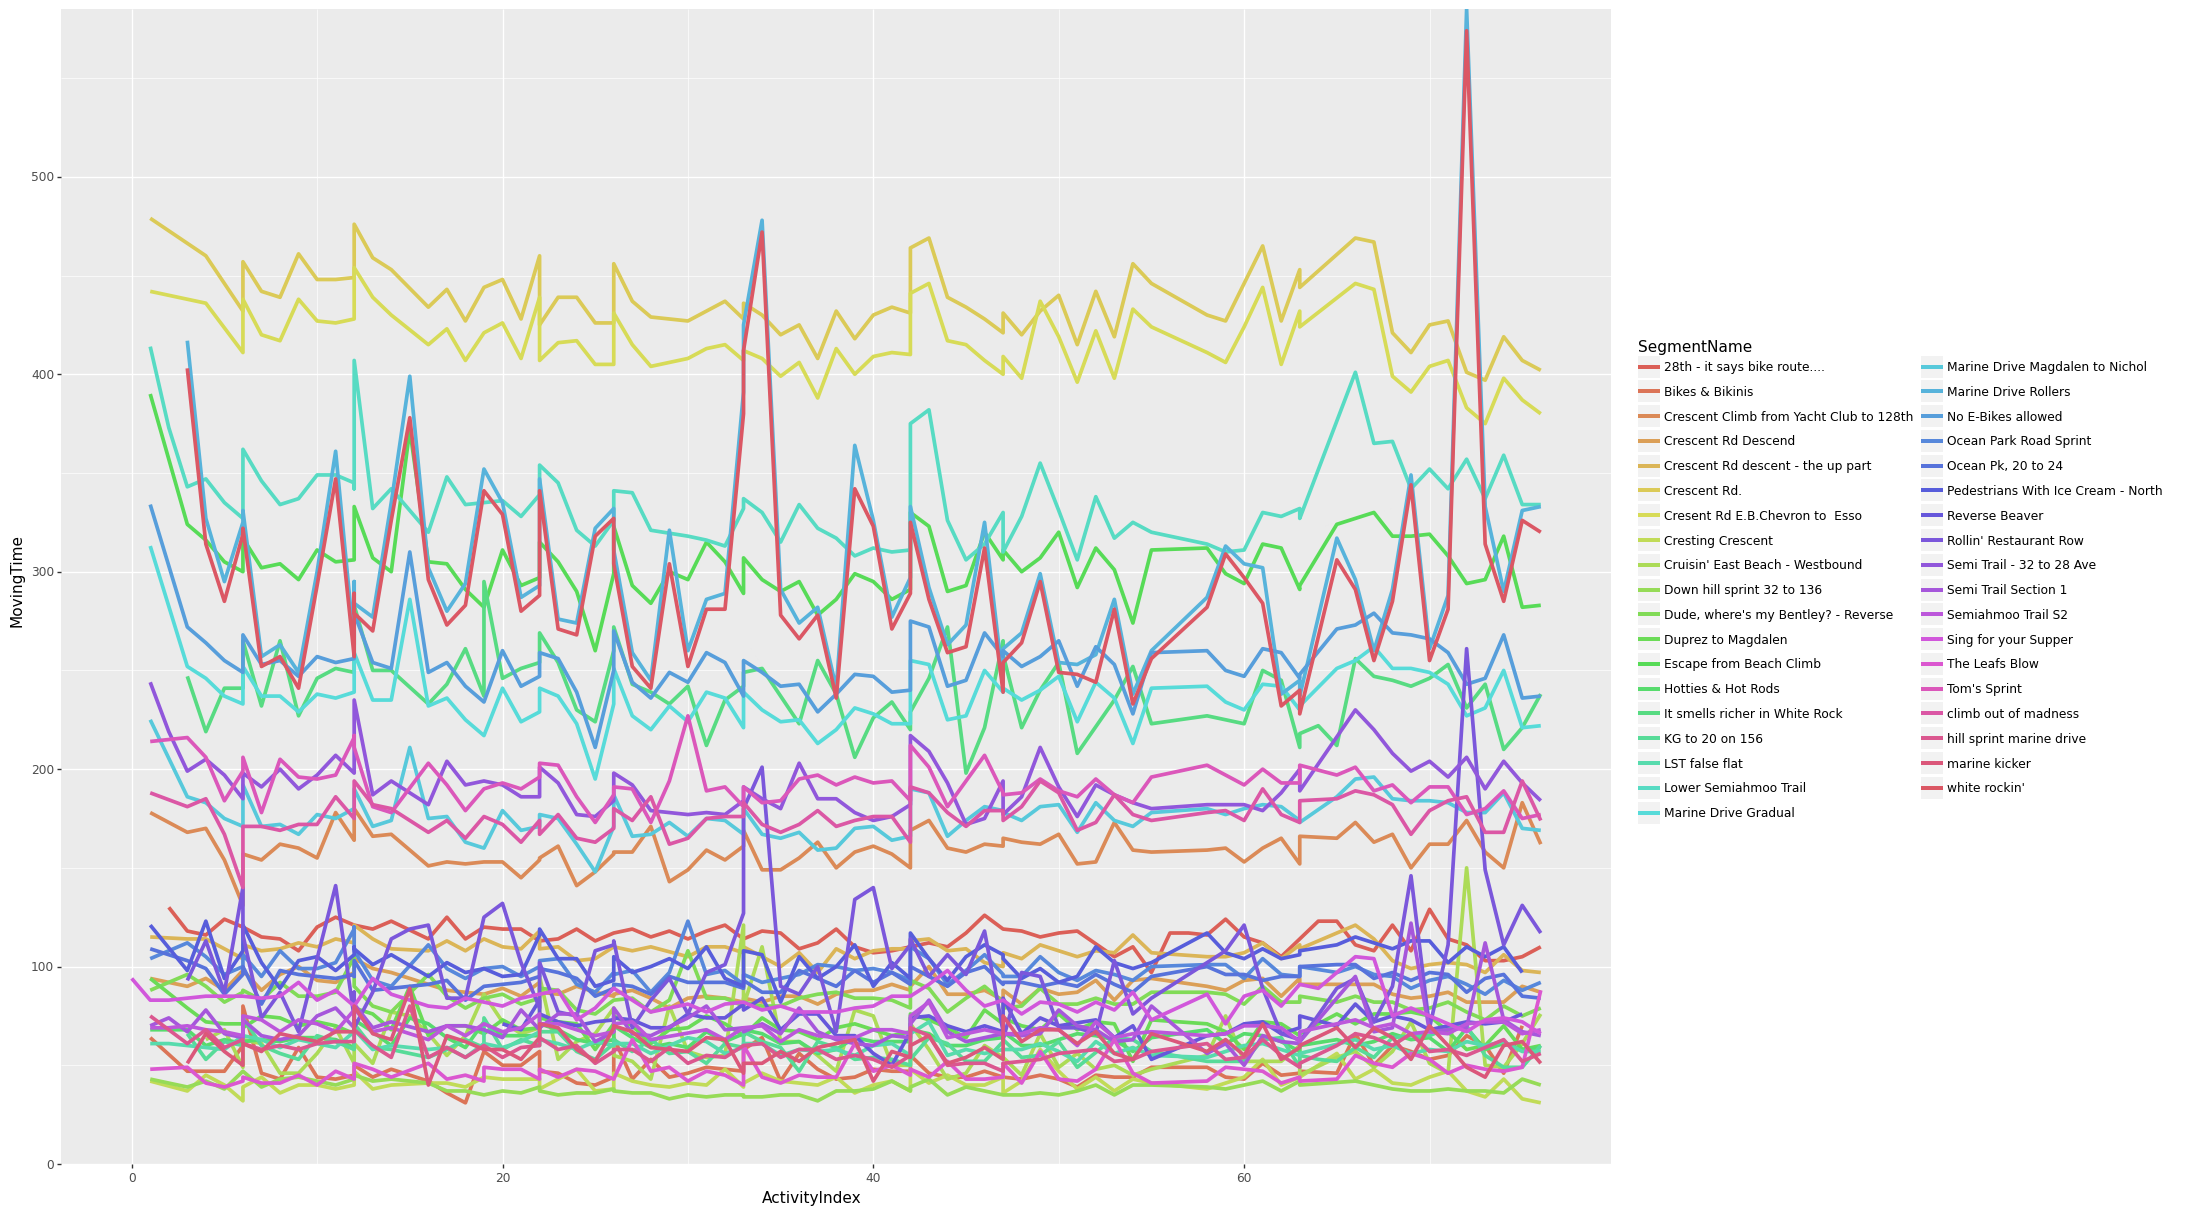

<ggplot: (828254115)>

In [17]:
# (gg.ggplot(eff_df.query('SegmentName.str.startswith("Cresent") | "Crescent Rd." in SegmentName'))
(gg.ggplot(eff_df)
    + gg.geom_line(gg.aes(x='ActivityIndex', y='MovingTime', colour='SegmentName'), size=1.5)

    + gg.scale_y_continuous(limits=[0, None], expand=(0, 0))
    
    + gg.theme(figure_size=(20, 15),
                )
 )

## Segments with plenty of elevation

In [18]:
elev_segments = {k: v for k, v in segments.items() if v.yoink_segment_stats()['average_grade'] < 1 and v.number_efforts > 50}
eff_df = []
for seg_id, seg in elev_segments.items():
    for effort in seg.efforts:
        eff_df.append([seg_id, segment_id_lookup[seg_id], effort.activity_id, effort.id, effort.start_date_local, effort.moving_time, effort.average_heartrate, effort.pr_rank])

eff_df = pd.DataFrame(eff_df, columns=['SegmentID', 'SegmentName', 'ActivityID', 'EffortID', 'DateTime', 'MovingTime', 'AverageHR', 'PRRank'])
eff_df['DateTime'] = pd.to_datetime(eff_df.DateTime)
eff_df['EffortIndex'] = eff_df.sort_values('DateTime').groupby('SegmentID').cumcount()

activity_index_lookup = {x: i for i, x in enumerate(sorted(eff_df.ActivityID.unique()))}
eff_df['ActivityIndex'] = eff_df.ActivityID.map(activity_index_lookup)
eff_df

AttributeError: 'Segment' object has no attribute 'yoink_segment_stats'

/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 158 rows containing missing values.
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 1541 rows containing missing values.


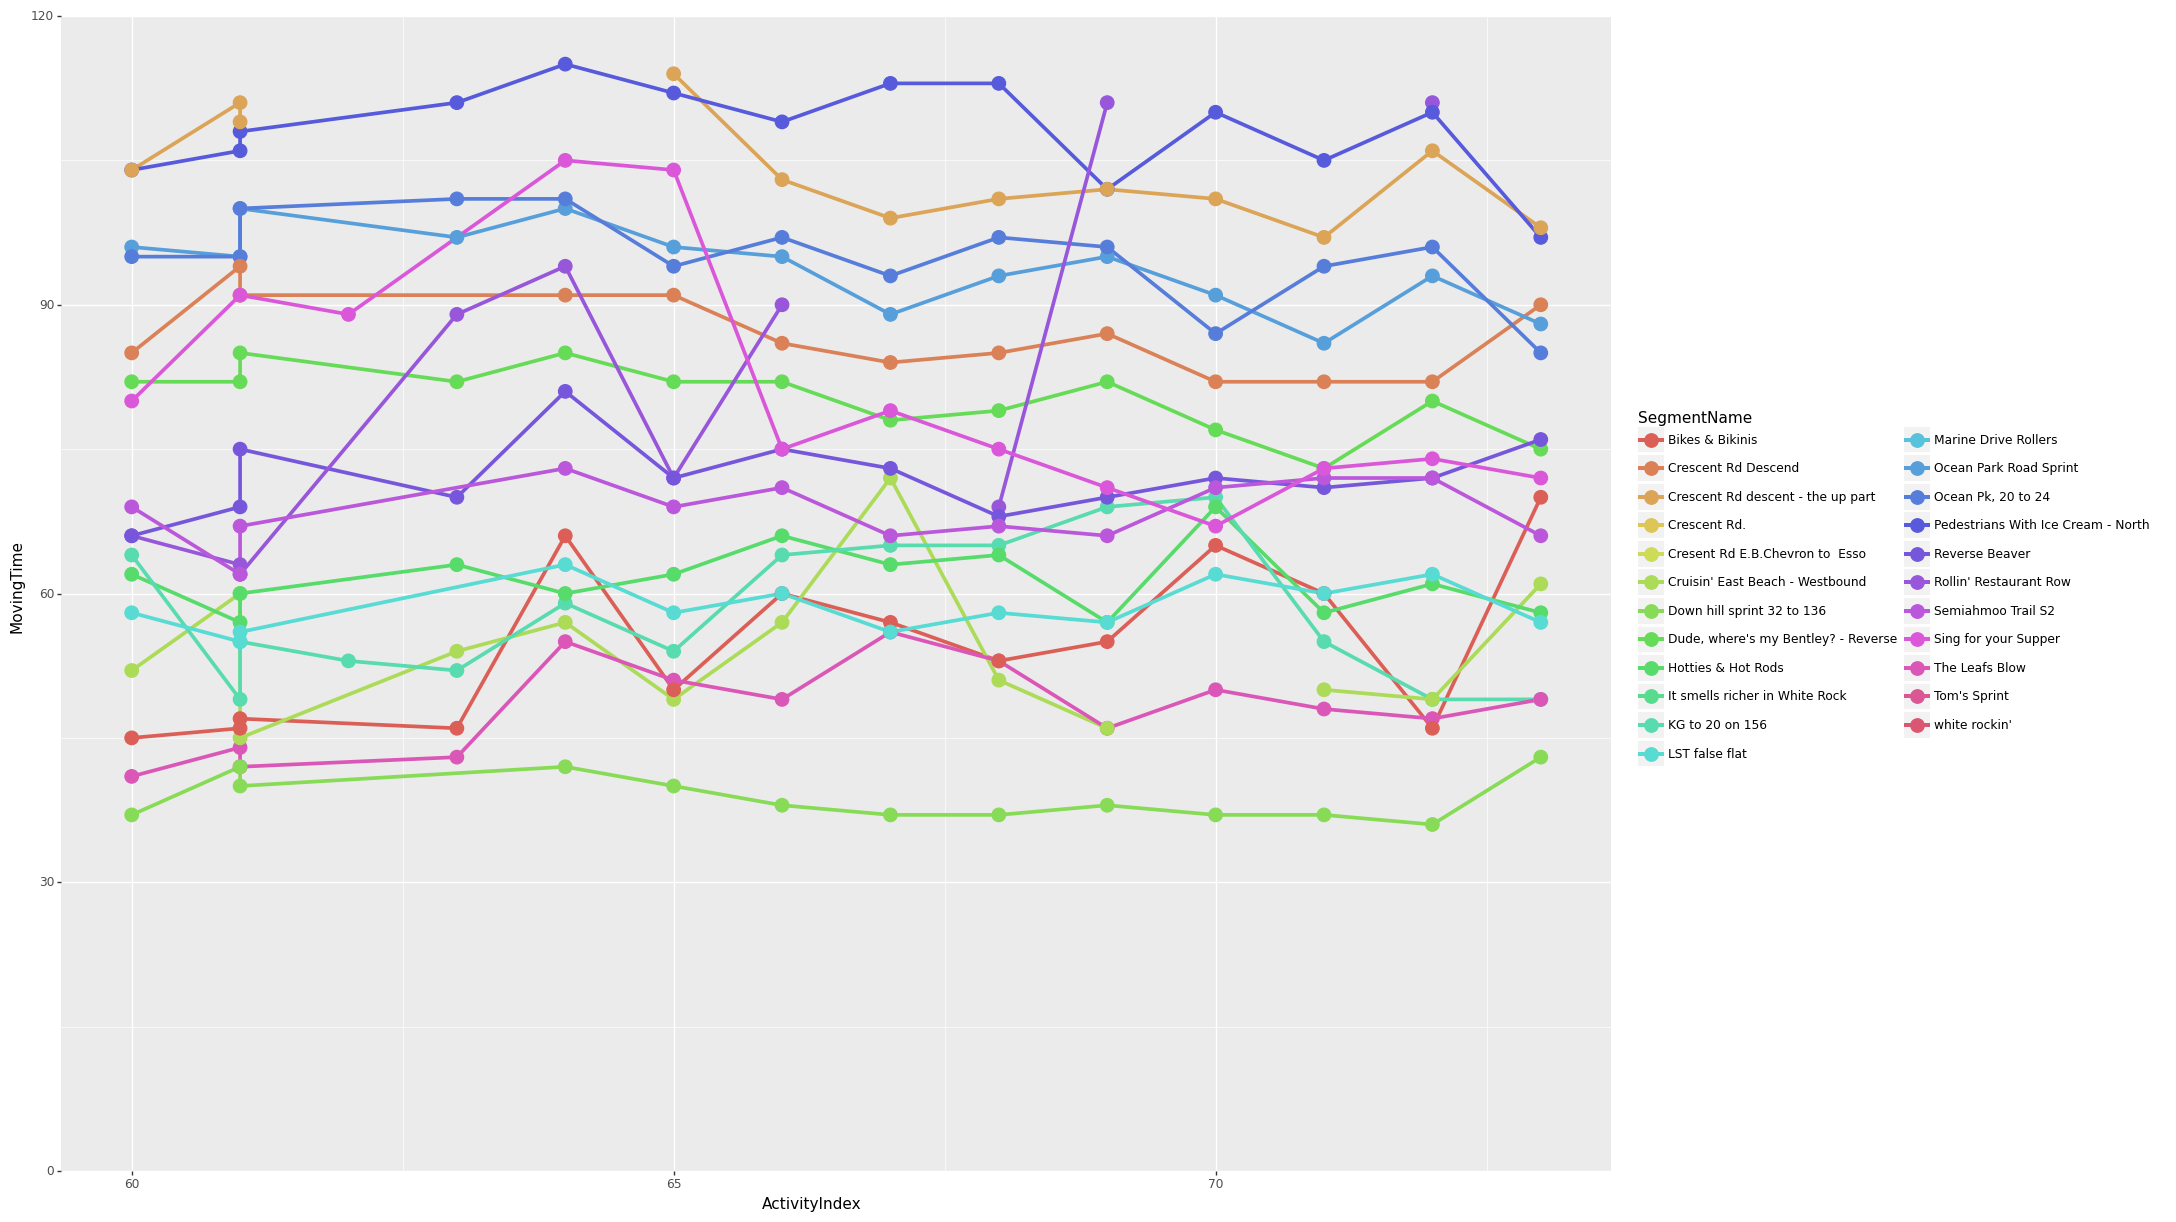

<ggplot: (850634452)>

In [ ]:
# (gg.ggplot(eff_df.query('SegmentName.str.startswith("Cresent") | "Crescent Rd." in SegmentName'))
(gg.ggplot(eff_df)
    + gg.geom_line(gg.aes(x='ActivityIndex', y='MovingTime', colour='SegmentName'), size=1.5)
    + gg.geom_point(gg.aes(x='ActivityIndex', y='MovingTime', colour='SegmentName'), size=5)

    + gg.scale_y_continuous(limits=[0, 120], expand=(0, 0))
    + gg.scale_x_continuous(limits=[60, None])
    
    + gg.theme(figure_size=(20, 15),
                )
 )

Very cool...

Would also be very cool to basically just use Strava's interface to explore segments and then be able to pull up the stats here by pasting the link or something.

Can make a view to see the last 15 or whatever efforts.

You can also request the segment, or segment effort streams, if that is helpful at all, might be neat for something like an effort check.

Create some premade filters like segments with large elevation change, or long ones, or short ones.

Activity Link: https://www.strava.com/activities/14307309734

Activity Segment Effort Link: https://www.strava.com/activities/14307309734/segments/3351715314413497486

Segment Link: https://www.strava.com/segments/14958585

https://strava.app.link/896fISkRWSb

In [ ]:
# Make a graph with the last X efforts.
# - The x-axis should be the dates of the efforts.
# - The y-axis should be an option between down to zero, and some sort of range, like 10% of the duration or enough to fit the data.
# - Can potentially add in some numbers to show the absolute time increases/decreases.  Maybe plot the speed and/or heartrate
# - Can plot a line of my total average, my last X average, and anything else

# This actually pulling all of the activities first and then searching them

In [8]:
def create_segment_catalog(activities: pd.DataFrame, activity_list: pd.DataFrame, activity_cache: Cache):
    """Create a catalog of the segments and efforts in activity_list.

    Args:
        activities (pd.DataFrame): Standard dataframe of the activities.
        activity_list (pd.DataFrame): Standard activities dataframe, filtered.
        activity_cache (Cache): Cache object of the activity cache.

    Returns:
        dict: Dictionay of {segment_id: Segment}
    """

    segments = {}
    # For each activity, get the activity detail 
    for act_id in activity_list.id:
        ad = get_activity_detail(activities, act_id, activity_cache, include_all_efforts=True)
        
        # For each effort in the activity
        for effort in ad['segment_efforts']:
            # If the segment is not already in the list, add it
            if effort['segment']['id'] not in segments:
                segments[effort['segment']['id']] = Segment(id=effort['segment']['id'])

            # Add the effort to the segment
            segments[effort['segment']['id']].add_effort(effort)
    
    return segments

In [9]:
# Find the BC activities by filtering to rides below latitude of 50
bc_activities = activities[activities.start_latlng.apply(lambda x: float(x[0])) < 50]
bc_segments = create_segment_catalog(activities, activity_list=bc_activities, activity_cache=activity_cache)

segment_id_lookup = {}
for k, v in bc_segments.items():
    print(f"{k}: {v.efforts[0].segment_name}: {v}")
    segment_id_lookup[k] = v.efforts[0].segment_name

Found activity 14307309734 in cache.
Found activity 14296525748 in cache.
Found activity 14277777811 in cache.
Found activity 14246648380 in cache.
Found activity 14218149073 in cache.
Found activity 14208696270 in cache.
Found activity 14180028159 in cache.
Found activity 14169893236 in cache.
Found activity 14150724069 in cache.
Found activity 14132622357 in cache.
Found activity 14082982033 in cache.
Found activity 14073578110 in cache.
Found activity 11214280814 in cache.
Found activity 10818058984 in cache.
Found activity 10045628823 in cache.
Found activity 10033794476 in cache.
Found activity 10028527513 in cache.
Found activity 10003148059 in cache.
Found activity 9996006537 in cache.
Found activity 9990461310 in cache.
Found activity 9985137901 in cache.
Found activity 9978987119 in cache.
Found activity 9946322578 in cache.
Found activity 9940528230 in cache.
Found activity 9911215580 in cache.
Found activity 9902256544 in cache.
Found activity 9890069161 in cache.
Found acti

https://www.strava.com/segments/1826138


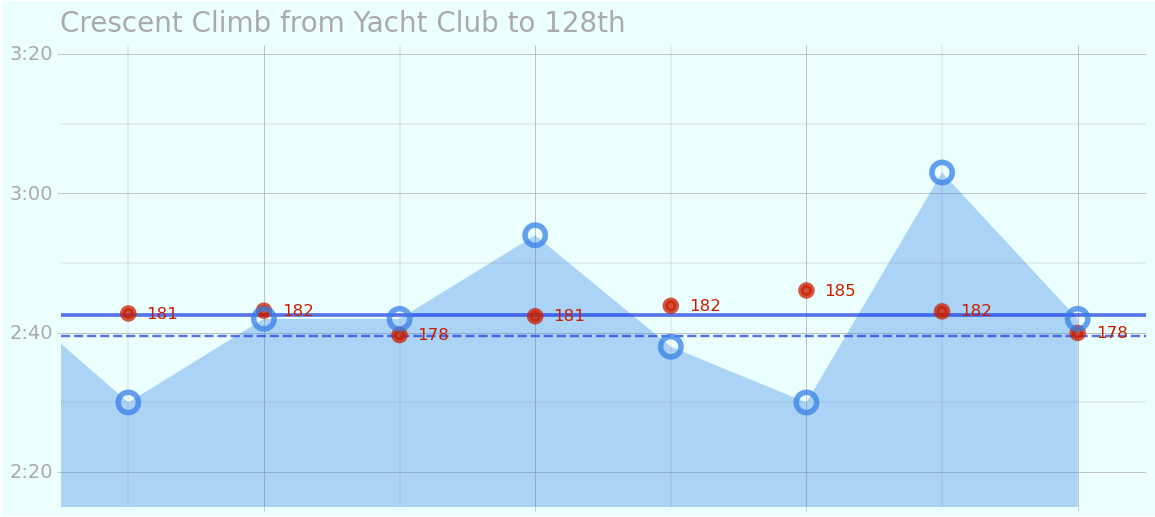

<ggplot: (830013810)>

In [76]:
segment_id = list(bc_segments.keys())[0] # marine kicker
segment_id = list(bc_segments.keys())[7] # marine kicker
segment_id = list(bc_segments.keys())[11] # Duprex to Magdalen
segment_id = list(bc_segments.keys())[21] # Crescent Climb
# for segment_id in bc_segments.keys():
segment_link = f'https://www.strava.com/segments/{segment_id}'
print(segment_link)
plot_df = bc_segments[segment_id].effort_df()
# if plot_df.shape[0] < 5:
#     continue

# Filtering and Such?
# - Filter to only a single effort per activity.  Have to reset the index on the activity, or I could base the index off of time instead of activity ID.


# Segment Information
segment_name = plot_df.SegmentName[0]

# Plot Controls and Calculations
previous_x = 8
plot_df_prev = plot_df[plot_df.DateTimeIndex > (plot_df.DateTimeIndex.max() - previous_x)]

# Colours
ribbon_colour = '#5FE4E7'
ribbon_colour = '#3481E7'
averages_colour = '#A343F6'
averages_colour = '#1A4F1B'
averages_colour = '#1638E5'
hr_colour = '#CA1E00'
# hr_colour = '#E74F59'
# hr_colour = stred

# --- X ---
# Full Range
xmin = 0
# Limit min to previous_x
xmin = plot_df.DateTimeIndex.max() - previous_x + 0.5
# Full Range
xmax = plot_df.DateTimeIndex.max() + 0.5

xlim = (xmin, xmax)

# --- Y ---
ymin = 0
# Full Range
# ymin = plot_df['MovingTime[s]'].min() * 0.9
ymax = plot_df['MovingTime[s]'].max() * 1.1
# Prevous x
ymin = plot_df_prev['MovingTime[s]'].min() * 0.9
ymax = plot_df_prev['MovingTime[s]'].max() * 1.1

ylim = (ymin, ymax)

# --- Ribbon ---
plot_df['xmin'] = xmin
plot_df['xmax'] = xmax
plot_df['ymin'] = ymin
plot_df['ymax'] = ymax

# --- Labels ---
plot_df['AverageHRLabel'] = plot_df.AverageHR.apply(lambda x: round(x))

# --- Averages ---
alltime_avg = plot_df['MovingTime[s]'].mean()
window_avg = plot_df_prev['MovingTime[s]'].mean()

# --- Heartrate Points ---
plot_df['AverageHRPlot'] = plot_df.AverageHR + plot_df_prev['MovingTime[s]'].mean() - plot_df_prev.AverageHR.mean()

g = (gg.ggplot(plot_df)
    # + gg.geom_ribbon(gg.aes(x='DateTimeIndex', ymin='AverageHRPlot', ymax='ymax'), fill=hr_colour, alpha=0.35)
    # + gg.geom_ribbon(gg.aes(x='DateTimeIndex', ymin='ymin', ymax='AverageHRPlot'), fill=hr_colour, alpha=0.35)
    + gg.geom_ribbon(gg.aes(x='DateTimeIndex', ymin='ymin', ymax='MovingTime[s]'), fill=ribbon_colour, alpha=0.35)

    + gg.geom_hline(gg.aes(yintercept=alltime_avg), size=1, colour=averages_colour, alpha=0.7, linetype='dashed')
    + gg.geom_hline(gg.aes(yintercept=window_avg), size=1.5, colour=averages_colour, alpha=0.7)

    + gg.geom_point(gg.aes(x='DateTimeIndex', y='AverageHRPlot'), size=2.2, alpha=0.75, stroke=2.25, colour=hr_colour)
    + gg.geom_point(gg.aes(x='DateTimeIndex', y='MovingTime[s]'), size=6, alpha=0.75, stroke=2.25, colour=ribbon_colour, fill="none")

    + gg.geom_text(gg.aes(x='DateTimeIndex + 0.25', y='AverageHRPlot', label='AverageHRLabel'), colour=hr_colour, size=12)

    + gg.coord_cartesian(xlim=xlim, ylim=ylim, expand=False)

    + gg.scale_y_continuous(labels=lambda y: [f"{x // 60:0.0f}:{x % 60:02.0f}" for x in y])

    + pt.gg_theme()
    + gg.theme(figure_size=(14, 6),
            panel_border=gg.element_blank(),
            axis_text=gg.element_text(size=18),
            axis_title=gg.element_text(size=24),
            axis_text_x=gg.element_blank(),
            axis_text_y=gg.element_text(size=14),
            plot_title=gg.element_text(size=20, ha='left'),
            )
    + gg.labs(x="", y="", title=segment_name,)
    
)
# g.save(filename=segment_plot_path + f"{segment_id}.png")
g

In [ ]:
# a
# distance
# average_grade, maximum_grade

{'id': 31582444,
 'resource_state': 2,
 'name': '28th - it says bike route....',
 'activity_type': 'Ride',
 'distance': 734.2,
 'average_grade': 2.0,
 'maximum_grade': 5.1,
 'elevation_high': 75.2,
 'elevation_low': 58.6,
 'start_latlng': [49.052882, -122.78008],
 'end_latlng': [49.052823, -122.790121],
 'elevation_profile': None,
 'elevation_profiles': None,
 'climb_category': 0,
 'city': 'Surrey',
 'state': 'British Columbia',
 'country': 'Canada',
 'private': False,
 'hazardous': False,
 'starred': False}

In [ ]:
# Would be neat to average out the times on a weekly or monthly basis to see if they're trending up/down

# Would be neat to put my average heartrate next to the circle, and maybe pull data about the activity in general?

# Would also be neat to add in some details about the segment.  Elevation, distance, grade, KOM time, Local legend count, if I hold any of them, or if I'm top 10, ...

# Would also be neat to see for each ride how many were above/below average for their segment.